## Model Tuning

In this worksheet, I'll be running the model and identifying potential sources of error. From the previous workbook, we'll import the initial model results.

In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNet,RidgeCV, ElasticNetCV
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures

import pickle


In [2]:
# dataframes as a variable
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)
    
with open('pickles/df_test.pkl', 'rb') as f:
    df_test = pickle.load(f)

In [3]:
# reading in variables

# variables import

with open('pickles/corr_list.pkl', 'rb') as f:
    corr_list = pickle.load(f)
    
with open('pickles/features.pkl', 'rb') as f:
    features = pickle.load(f)
    
with open('pickles/ridge.pkl', 'rb') as f:
    ridge_cv = pickle.load(f)


### Summary of Model

As previously stated, the model I used was a Ridge Regression. This model achieved an R2 score of .85 on the training data and .84 on the testing data. Due to how tightly correlated the test and training R2 scores were, I believe that this model would provided beneficial insight into the broader residential real estate market in Ames, Iowa.

Due to the consistency of the model when exposed to new data, this model is reliable and can easily be applied to additional data as it becomes available.


#### Baseline Comparison

After running the model on our training data, we saw significant improvements on both R2 and RMSE. The baseline R2 value was ~0 and was improved to .855. A similar trend is established with RMSE, where the baseline RMSE was at ~81,039 and was reduced to 30,119.

The baseline y_pred (y_median) was calculated to be $164,900. Therefore this difference in RMSE is significant.

### Visualizations

From the data that was extracted from our analysis, I'll use this section to illustrate any important take-aways.

#### Working Variables and Dataframes



In [4]:
X = df.drop(columns='saleprice')
y = df[['saleprice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### 20 Most Positive Features

In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit Ridge model to training data using cross-validation to select alpha
ridge = RidgeCV(alphas=[0.1, 1, 10, 100, 1000], cv=5)
ridge.fit(X_train, y_train)

# Get best alpha value and coefficients
best_alpha = ridge.alpha_
coefs = ridge.coef_.ravel()

# Create DataFrame of coefficients and sort by absolute value
coef_df = pd.DataFrame({'coef': coefs}, index=X_test.columns)
coef_df['abs_coef'] = (coef_df['coef'])
coef_df = coef_df.sort_values(by='abs_coef', ascending=True)

# Print DataFrame
print(coef_df)

                              coef      abs_coef
misc feature_Elev    -36638.302203 -36638.302203
neighborhood_Edwards -12647.678585 -12647.678585
land contour_Bnk     -11902.483332 -11902.483332
neighborhood_OldTown -11623.669396 -11623.669396
garage qual_TA       -10058.055700 -10058.055700
...                            ...           ...
neighborhood_NridgHt  20980.735545  20980.735545
kitchen qual_Ex       22433.747481  22433.747481
neighborhood_StoneBr  23077.052341  23077.052341
gr liv area           23891.373722  23891.373722
neighborhood_NoRidge  24361.416947  24361.416947

[259 rows x 2 columns]


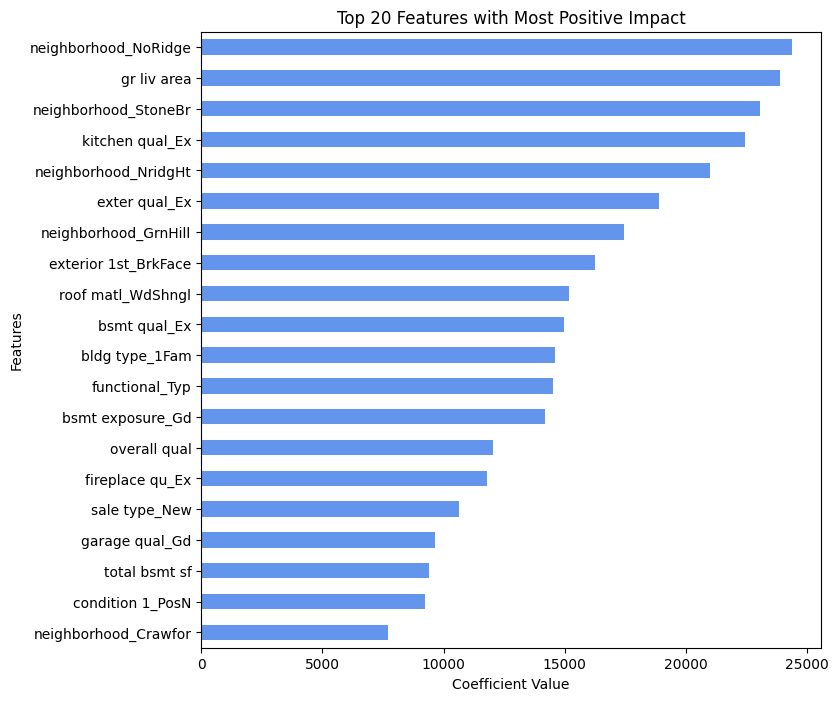

In [6]:
# Plot top 20 positive features
plt.figure(figsize=(8,8), facecolor='white')
coef_df['coef'].tail(20).plot(kind='barh',color = 'cornflowerblue')
plt.title('Top 20 Features with Most Positive Impact')
plt.xlabel('Coefficient Value')
plt.ylabel('Features');

The Neighborhood feature represents a stratifying variable in our analysis. As you'll see in the above bar chart, both the Green Hill & North Ridge Neighborhoods had the highest overall impact on sale price. Below, you'll also see that the Neighborhood Meadow Valley had a large negative impact.

Because of this stratification of coefs between each individual neighborhood feature, generally Neighborhoods were poor predictors of overall sale price. That said, given a specific neighborhood, the relationship is much more clear.

#### 20 Most Negative Features

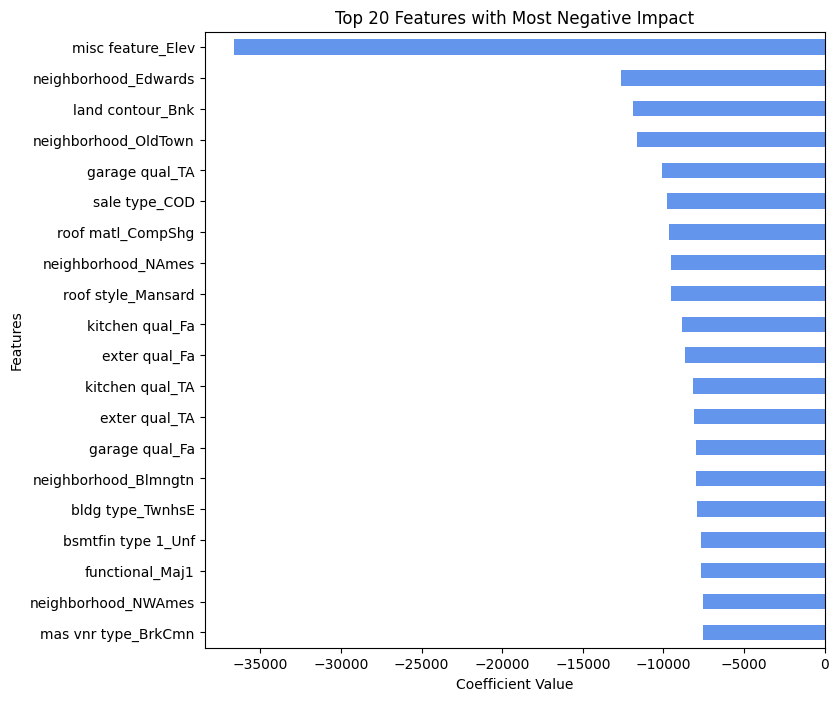

In [7]:
# Plot of 20 most negative features as an impact to
coef_df.sort_values(by='coef', ascending=False, inplace=True)
plt.figure(figsize=(8,8), facecolor='white')
coef_df['coef'].tail(20).plot(kind='barh', color = 'cornflowerblue')
plt.title('Top 20 Features with Most Negative Impact')
plt.xlabel('Coefficient Value')
plt.ylabel('Features');

The relationship between the presence of elevators within a home amy be tied strongly to the housing type and zoning classification. It's likely that elevators are present more often in condos or large buildings where each unit is sold individually. Additionally, it's unlikely that a single family home with an elevator would be within a standard deviation of the mean home value. Further analysis would need to be completed to flush out this relationship

#### Prediction Accuracy from our Ridge Regression

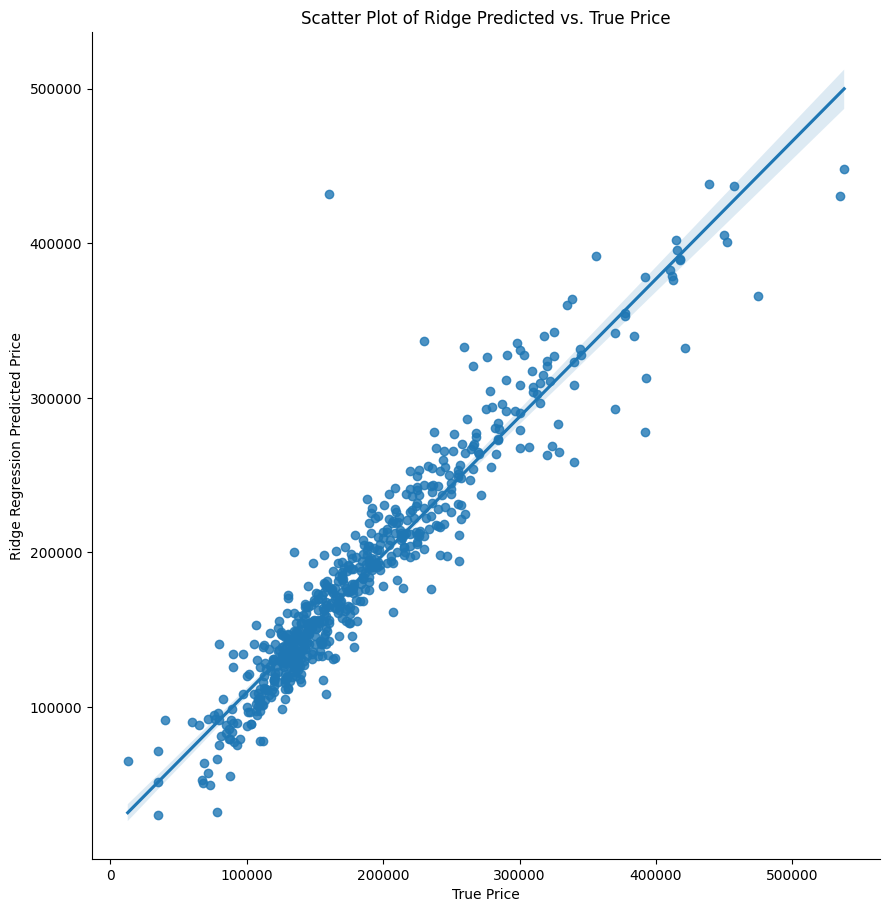

In [8]:
# Look at prediction accuracy
custom_palette = sns.color_palette(['purple'])

y_hat = ridge_cv.predict(X_test)
plot_df = pd.DataFrame()
plot_df['true'], plot_df['pred'] = y_test, y_hat
sns.lmplot(x='true', y='pred', data=plot_df, height=9, palette=custom_palette)
plt.title('Scatter Plot of Ridge Predicted vs. True Price')
plt.xlabel('True Price')
plt.ylabel('Ridge Regression Predicted Price')
plt.show()

This scatterplot shows the relative strength of our model. There are outliers shown within the plot that don't alter the general trend of our trend. Further cleaning and engineering of our data would improve this result.

#### Price by Neighborhood

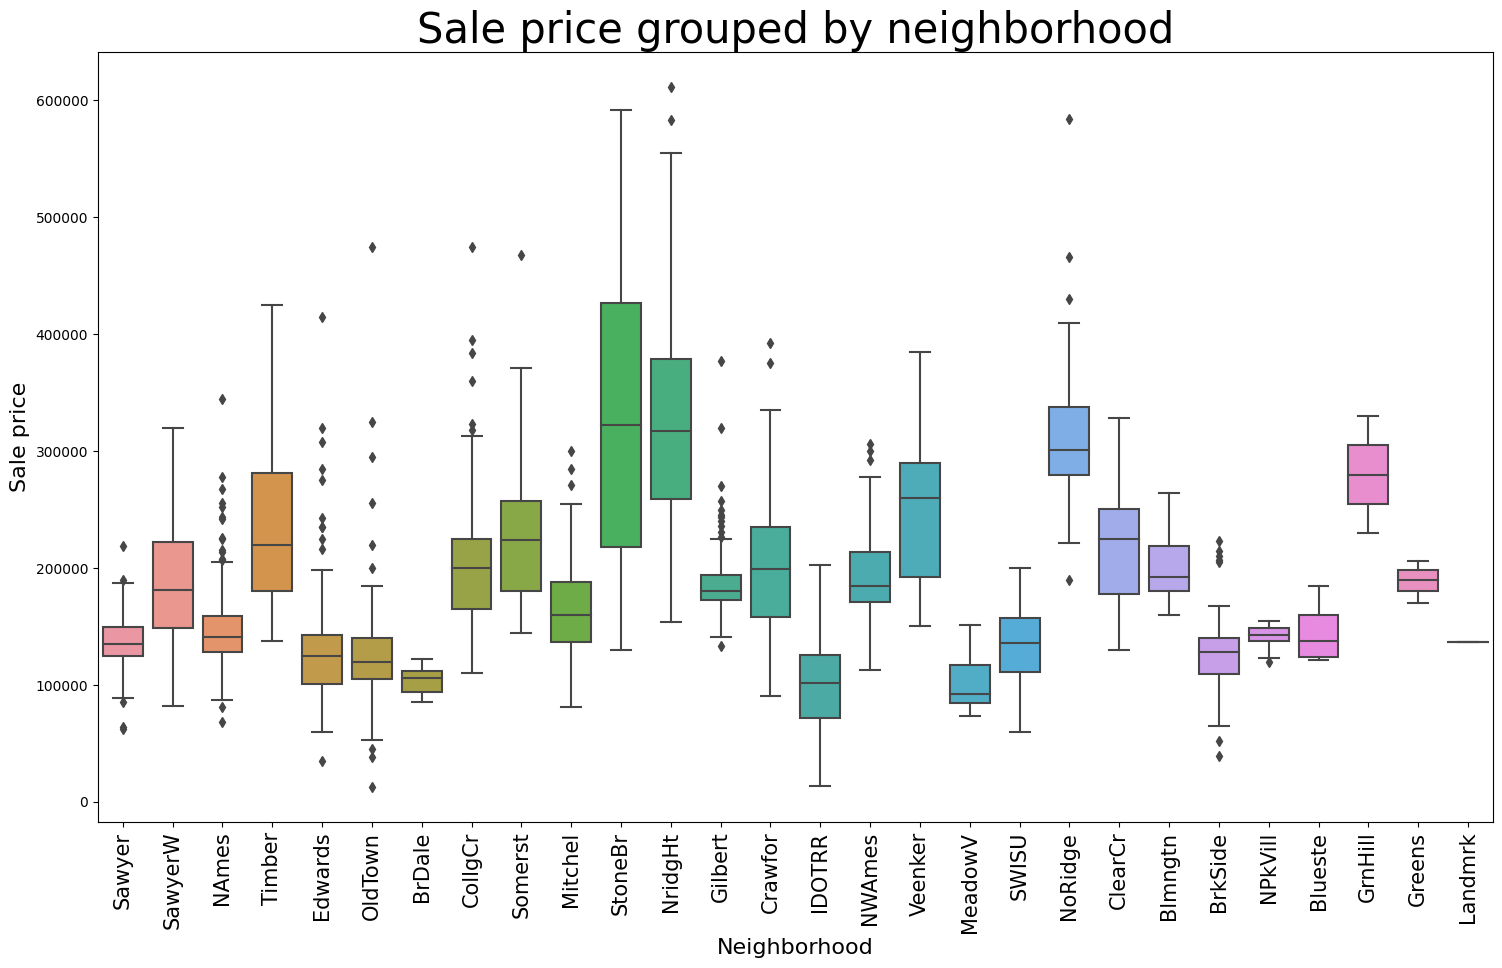

In [11]:
df_pre = pd.read_csv('../datasets/train.csv')

plt.figure(figsize=(18,10))
sns.boxplot(x=df_pre['Neighborhood'], y=df_pre['SalePrice'])
plt.title('Sale price grouped by neighborhood', fontsize=30)
plt.xlabel('Neighborhood', fontsize=16)
plt.ylabel('Sale price', fontsize=16)
plt.xticks(size=15,rotation='vertical');

In the previous figure we saw how important neighborhood can be. From the perspective of a developer, using neighborhood to further tune this model would be tremendously beneficial for predicting price. The model would be improved if it were applied to homes in an individual neighborhood, as the price of a home will follow a tighter range.

#### Distribution of Sale Price

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_65973/1365028135.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['saleprice'],color='black', hist_kws={'edgecolor':'cornflowerblue', 'linewidth': 3, 'color':'cornflowerblue'})


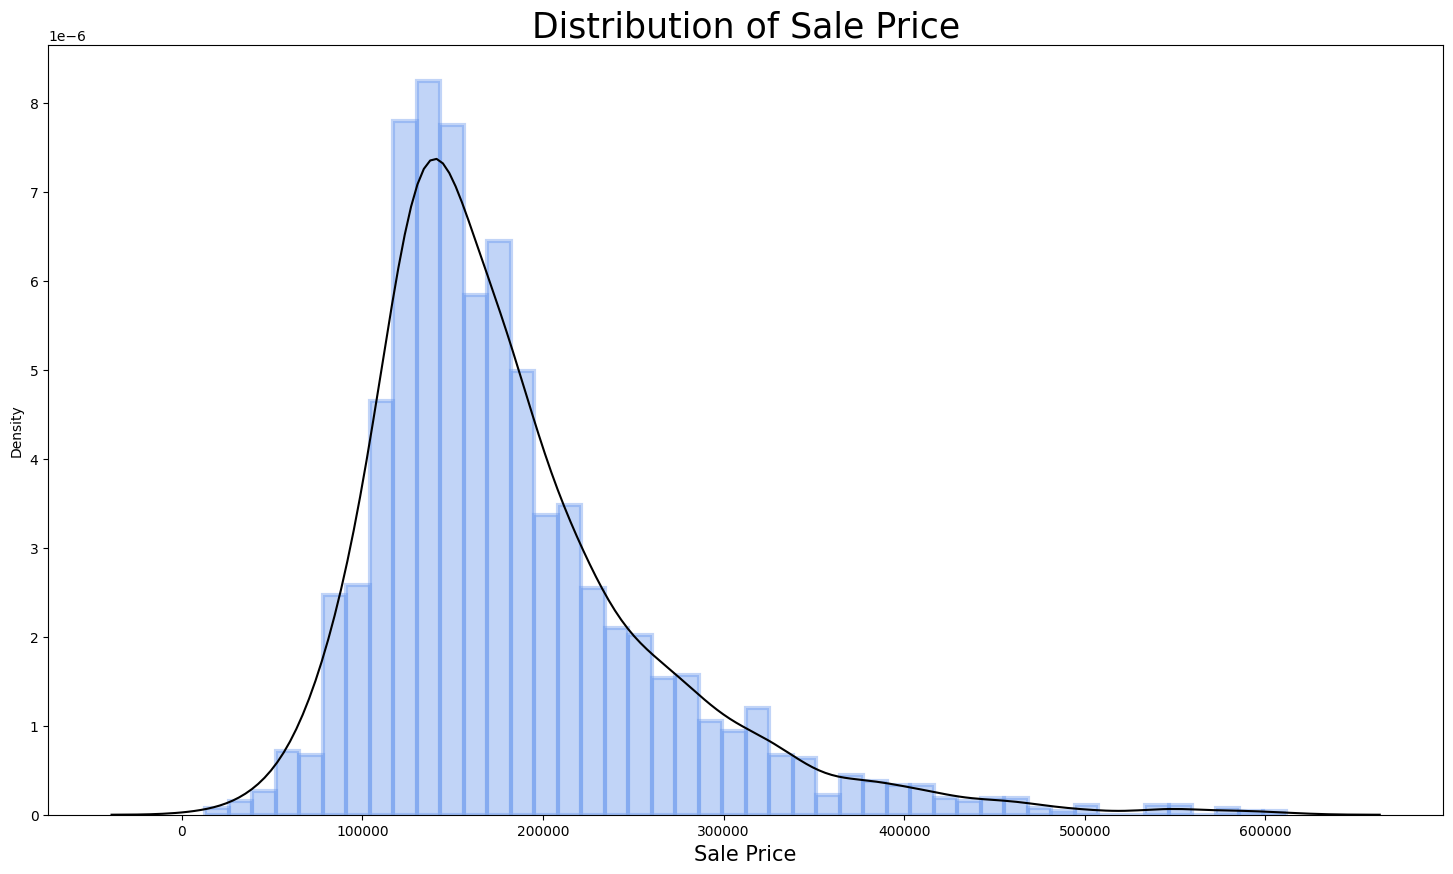

In [10]:
plt.figure(figsize = (18,10))
sns.distplot(df['saleprice'],color='black', hist_kws={'edgecolor':'cornflowerblue', 'linewidth': 3, 'color':'cornflowerblue'})
plt.title('Distribution of Sale Price', fontsize=25)
plt.tick_params(labelsize=10)
plt.xlabel('Sale Price', fontsize=15);

### Conclusion

* The dataset was imperfect and needed a significant amount of cleaning to make it usable for the stated purpose

* Null values were handled accordingly as stated in the data dictionary. The type of data that the null represented dictated what type of action was taken.

* These null values created a limitation in the data and created outliers that were difficult to handle without creating issues within our model

* Additional data regarding the surrounding features would further improve the model, as most of the features pertained to the homes themselves, rather than the auxillary features of the region (flood levels, natural disaster propensity, proximity to critical facilities, etc.)

* Within my analysis, I identified several features that are valuable in predicting the price of a home in the area. Those features are, but not limited to:

 - Neighborhoods: Green hills, StoneBrook, and Northridge
 - 2.5 storey homes (finished)
 - Wood shingle Roofs
 
 Features that show a negative correlation with price:
 
 - Elevators (Misc. Feature)
 - Composite shingle roofs
 - Homes in the Meadow Valley neighborhood
 
 
 
 

### Recommendations

* As stated in the conclusion, more data regarding regional features would likely improve the model, all things equal
* This model is unlikely to provide useful analysis for areas outside of Ames. This is due to the significant impact the Neighborhood features had in the results
* This model will predict home values more precisely within a given neighborhood, rather than generalized throughout the city
* Further analysis could be completed to improve the model given additional data